In [68]:
################################################################################
# Librerías
################################################################################

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# Algoritmos
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

# Evaluación
from sklearn.metrics import classification_report, \
                            confusion_matrix, \
                            plot_confusion_matrix

In [57]:
################################################################################
# Lectura
################################################################################

# Cargamos los datos (Raw Data nos es más cómodo que Data)
data = pd.read_excel("data/CTG.xls", "Raw Data")

# Eliminamos las 3 últimas filas que solo contienen valores de máximos y mínimos
data = data[:-3]

# Eliminamos las primera fila que está vacía
data = data[1:]

# Eliminamos la primeras dos columnas pues no contienen información relevante
# para la clasificación
removed_columns = ["FileName", "Date", "SegFile", "b", "e", "A", "B", "C", "D",
                    "AD", "DE", "LD", "FS", "SUSP", "CLASS"]
data = data.drop(columns=removed_columns)

print("Data:")
print(data)

labels = data.pop("NSP")
labels = pd.Categorical(labels)
labels = labels.rename_categories(["N", "S", "P"])
labels_names = ["Normal", "Suspect", "Pathologic"]



Data:
        LBE     LB   AC   FM   UC  ASTV  MSTV  ALTV  MLTV   DL  ...    Max  \
1     120.0  120.0  0.0  0.0  0.0  73.0   0.5  43.0   2.4  0.0  ...  126.0   
2     132.0  132.0  4.0  0.0  4.0  17.0   2.1   0.0  10.4  2.0  ...  198.0   
3     133.0  133.0  2.0  0.0  5.0  16.0   2.1   0.0  13.4  2.0  ...  198.0   
4     134.0  134.0  2.0  0.0  6.0  16.0   2.4   0.0  23.0  2.0  ...  170.0   
5     132.0  132.0  4.0  0.0  5.0  16.0   2.4   0.0  19.9  0.0  ...  170.0   
...     ...    ...  ...  ...  ...   ...   ...   ...   ...  ...  ...    ...   
2122  140.0  140.0  0.0  0.0  6.0  79.0   0.2  25.0   7.2  0.0  ...  177.0   
2123  140.0  140.0  1.0  0.0  9.0  78.0   0.4  22.0   7.1  0.0  ...  169.0   
2124  140.0  140.0  1.0  0.0  7.0  79.0   0.4  20.0   6.1  0.0  ...  170.0   
2125  140.0  140.0  1.0  0.0  9.0  78.0   0.4  27.0   7.0  0.0  ...  169.0   
2126  142.0  142.0  1.0  1.0  5.0  74.0   0.4  36.0   5.0  0.0  ...  159.0   

      Nmax  Nzeros   Mode   Mean  Median  Variance  Tende

In [59]:
################################################################################
# Preprocesamiento
################################################################################

# Como tenemos bastantes datos, separamos un 20% para test
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

# Calculamos PCA sobre train
n_components = 5    # Bajo porque los tres modelos que tenemos tienden a 
                    # sobreajustar
pca = PCA(n_components=n_components, svd_solver="randomized", 
            whiten=True).fit(x_train) # No queremos variables correladas ?

# Aplicamos PCA
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

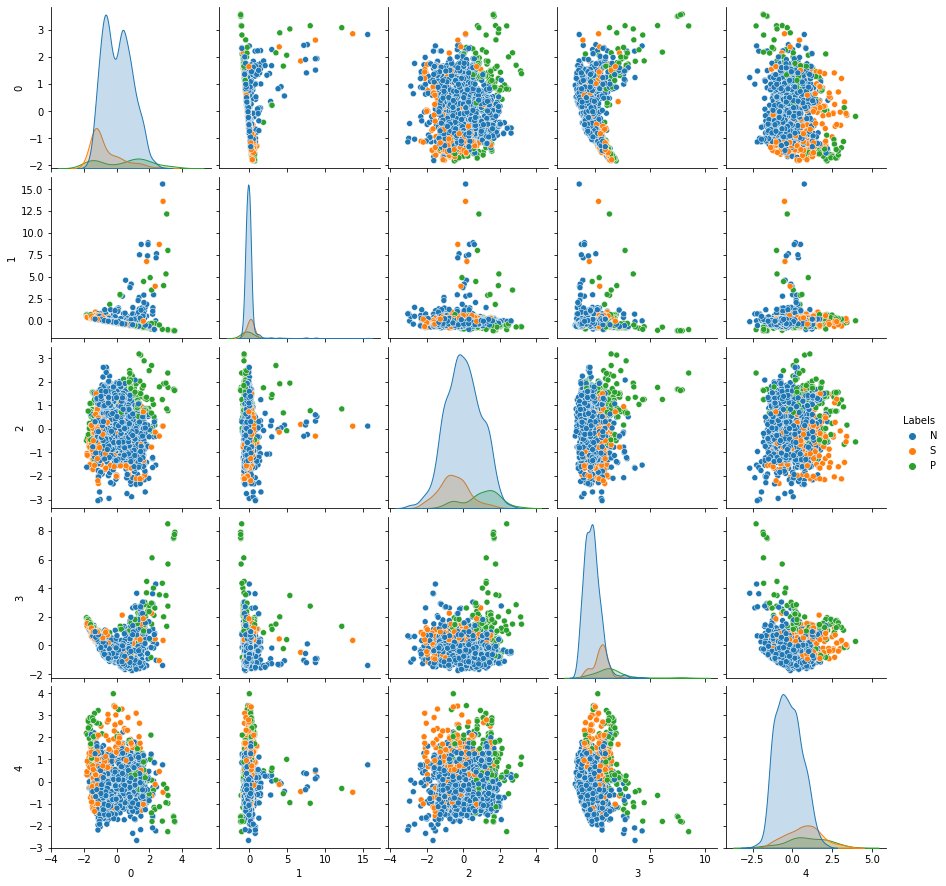

In [60]:
# ------------------------------------------------------------------------------
# Mostramos algunos gráficos

df = pd.DataFrame(x_train_pca)
# df["Labels"] = pd.factorize(y_train)
df["Labels"] = y_train

sns.pairplot(df, hue="Labels")#.savefig("pair.png")



In [58]:
pd

['S', 'N', 'N', 'N', 'N', ..., 'S', 'S', 'S', 'S', 'N']
Length: 2126
Categories (3, object): ['N', 'S', 'P']

------------------------------------------------------------------
Clasificando con SVM
------------------------------------------------------------------
Mejores hiperparámetros del modelo:
{'C': 1000.0, 'gamma': 0.01, 'kernel': 'poly'}

Mejor score obtenido:
0.8647058823529411

Resultados de la predicción sobre test:
              precision    recall  f1-score   support

      Normal       0.93      0.91      0.92       327
     Suspect       0.76      0.82      0.78        38
  Pathologic       0.60      0.66      0.62        61

    accuracy                           0.86       426
   macro avg       0.76      0.79      0.78       426
weighted avg       0.87      0.86      0.86       426

Matriz de confusión:
[[296   7  24]
 [  4  31   3]
 [ 18   3  40]]


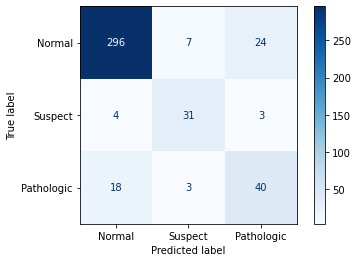

In [61]:
################################################################################
# Clasificando con SVM
################################################################################
print("------------------------------------------------------------------")
print("Clasificando con SVM")
print("------------------------------------------------------------------")

# Declaración de hiperparámetros
param_grid = {
    "C": [10, 1e3, 1e5],        # Valores de regularización
    "gamma": [0.01, 0.001],     #
    "kernel": ["rbf", "poly"]   # Kernel polinomial o ?
}

# Test de hiperparámetros con cross-validation de 5 folds
clf = GridSearchCV(SVC(class_weight="balanced"), 
                    param_grid)
clf = clf.fit(x_train_pca, y_train)

print("Mejores hiperparámetros del modelo:")
print(clf.best_params_)
print("\nMejor score obtenido:")
print(clf.best_score_)

# Guardamos el mejor estimador
best_svm = clf.best_estimator_

#############################
# Evaluación final del modelo
#############################

y_pred = clf.predict(x_test_pca)

print("\nResultados de la predicción sobre test:")
print(classification_report(y_test, y_pred, target_names=labels_names))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# ------------------------------------------------------------------------------
# Mostramos gráficos sobre los resultados
disp = plot_confusion_matrix(best_svm, x_test_pca, y_test,
                                display_labels=labels_names, cmap=plt.cm.Blues)
plt.show()
# plt.savefig("prueba.png")



------------------------------------------------------------------
Clasificando con KNN
------------------------------------------------------------------
Mejores hiperparámetros del modelo:
{'n_neighbors': 5, 'weights': 'distance'}

Mejor score obtenido:
0.8805882352941176

Resultados de la predicción sobre test:
              precision    recall  f1-score   support

      Normal       0.92      0.96      0.94       327
     Suspect       0.91      0.79      0.85        38
  Pathologic       0.71      0.57      0.64        61

    accuracy                           0.89       426
   macro avg       0.85      0.78      0.81       426
weighted avg       0.89      0.89      0.89       426

Matriz de confusión:
[[315   2  10]
 [  4  30   4]
 [ 25   1  35]]


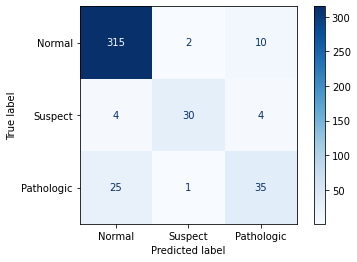

In [66]:
################################################################################
# Clasificando con KNN
################################################################################
print("------------------------------------------------------------------")
print("Clasificando con KNN")
print("------------------------------------------------------------------")

# Declaración de hiperparámetros
param_grid = {
    "n_neighbors" : [3, 5, 7, 10, 13, 15],     # Diferentes valores de K
    "weights": ["uniform", "distance"]   # Selección ponderada por distancia o no
}

# Test de hiperparámetros
clf = GridSearchCV(KNeighborsClassifier(), param_grid)
clf = clf.fit(x_train_pca, y_train)

print("Mejores hiperparámetros del modelo:")
print(clf.best_params_)
print("\nMejor score obtenido:")
print(clf.best_score_)

# Guardamos el mejor estimador
best_knn = clf.best_estimator_

#############################
# Evaluación final del modelo
#############################

y_pred = clf.predict(x_test_pca)

print("\nResultados de la predicción sobre test:")
print(classification_report(y_test, y_pred, target_names=labels_names))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# ------------------------------------------------------------------------------
# Mostramos gráficos sobre los resultados
disp = plot_confusion_matrix(best_knn, x_test_pca, y_test,
                                display_labels=labels_names, cmap=plt.cm.Blues)
plt.show()


------------------------------------------------------------------
Clasificando con Random Forest
------------------------------------------------------------------
Mejores hiperparámetros del modelo:
{'max_depth': None, 'n_estimators': 500}

Mejor score obtenido:
0.8852941176470589

Resultados de la predicción sobre test:
              precision    recall  f1-score   support

      Normal       0.92      0.96      0.94       327
     Suspect       0.94      0.82      0.87        38
  Pathologic       0.75      0.64      0.69        61

    accuracy                           0.90       426
   macro avg       0.87      0.81      0.84       426
weighted avg       0.90      0.90      0.90       426

Matriz de confusión:
[[315   1  11]
 [  5  31   2]
 [ 21   1  39]]


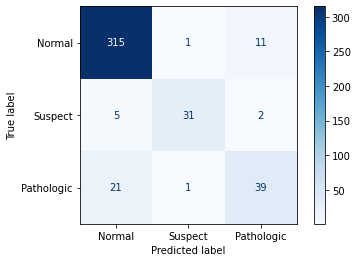

In [69]:
################################################################################
# Clasificando con Random Forest
################################################################################
print("------------------------------------------------------------------")
print("Clasificando con Random Forest")
print("------------------------------------------------------------------")


# Declaración de hiperparámetros
param_grid = {
    "n_estimators" : [10, 50, 100, 200, 500],    # Nº de árboles
    "max_depth" : [None, 20]    # Permitir crecer a los árboles o hacer poda
}

# Test de hiperparámetros
clf = GridSearchCV(RandomForestClassifier(), param_grid)
clf = clf.fit(x_train_pca, y_train)

print("Mejores hiperparámetros del modelo:")
print(clf.best_params_)
print("\nMejor score obtenido:")
print(clf.best_score_)

# Guardamos el mejor estimador
best_rf = clf.best_estimator_

#############################
# Evaluación final del modelo
#############################

y_pred = clf.predict(x_test_pca)

print("\nResultados de la predicción sobre test:")
print(classification_report(y_test, y_pred, target_names=labels_names))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# ------------------------------------------------------------------------------
# Mostramos gráficos sobre los resultados
disp = plot_confusion_matrix(best_rf, x_test_pca, y_test,
                                display_labels=labels_names, cmap=plt.cm.Blues)
plt.show()